In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import os
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

In [2]:
if torch.cuda.is_available():
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

CUDA is available! Training on GPU...


In [3]:
# Define the directory path
train_directory_path = r'C:\Users\anonymoususer\OneDrive\Desktop\BGprediction\LB_split\training'  # Use a raw string for paths on Windows

# List files without their extensions
train_file_names = [os.path.splitext(file)[0] for file in os.listdir(train_directory_path)
              if os.path.isfile(os.path.join(train_directory_path, file))]

# Print the list of file names
print(train_file_names)

# subject = pd.read_csv(f"../LB_split/training/63_training_data.csv")

['1343_training_data', '1617_training_data', '255_training_data', '354_training_data', '695_training_data', '816_training_data', '854_training_data', '856_training_data', '862_training_data', '894_training_data', '900_training_data', '907_training_data', '953_training_data', '979_training_data', '981_training_data', '987_training_data']


In [4]:
def preprocess_t1dexi(path):

    subject = pd.read_csv(path)
    subject['LBDTC'] = pd.to_datetime(subject['LBDTC'], errors='coerce')  # Convert 'date' column to datetime if not already
    # print(subject['date'][0])
    subject.sort_values('LBDTC', inplace=True)  # Sort the DataFrame by the 'date' column

    # Assuming self.interval_timedelta is set, for example:
    interval_timedelta = datetime.timedelta(minutes=6)  # Example timedelta of 6 minutes, providing a range for latency

    # Create a list to store the results
    res = []

    # Initialize the first group
    if not subject.empty:
        current_group = [subject.iloc[0]['LBORRES']]
        last_time = subject.iloc[0]['LBDTC']

    # Iterate over rows in DataFrame starting from the second row
    for index, row in subject.iloc[1:].iterrows():
        current_time = row['LBDTC']
        if (current_time - last_time) <= interval_timedelta:
            # If the time difference is within the limit, add to the current group
            current_group.append(row['LBORRES'])
        else:
            # Otherwise, start a new group
            res.append(current_group)
            current_group = [row['LBORRES']]
        last_time = current_time

    # Add the last group if it's not empty
    if current_group:
        res.append(current_group)
    
    # Filter out groups with fewer than 10 glucose readings
    res = [group for group in res if len(group) >= 10]

    return res

In [5]:
def preprocess_OhioT1DM(path):
    tree = ET.parse(path)
    root = tree.getroot()
    interval_timedelta = datetime.timedelta(minutes=6)

    res = []
    for item in root.findall("glucose_level"):
        entry0 = item[0].attrib
        res.append([float(entry0["value"])])
        for i in range(1, len(item)):
            last_entry = item[i - 1].attrib
            entry = item[i].attrib
            t1 = datetime.datetime.strptime(entry["ts"], "%d-%m-%Y %H:%M:%S")
            t0 = datetime.datetime.strptime(last_entry["ts"], "%d-%m-%Y %H:%M:%S")
            delt = t1 - t0
            if delt <= interval_timedelta:
                res[-1].append(float(entry["value"]))
            else:
                res.append([float(entry["value"])])
    return res



In [ ]:
res = preprocess_t1dexi(f"../LB_split/training/63_training_data.csv")

In [7]:
def create_sequences(data, seq_length, pred_step):
    """
    Create sequences and targets from time series data.

    Args:
    data (list or ndarray): The time series data.
    seq_length (int): Length of the sequence.
    pred_step (int): Steps ahead to predict.

    Returns:
    tuple of torch.Tensors: sequences and targets.
    """
    sequences = []
    targets = []
    for i in range(len(data) - seq_length - pred_step + 1):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length+pred_step-1])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


# reconstruct_data = create_sequences(res[0], 6, 3)

In [8]:
# Loop thru all subjects to stack the data
X_stack_tensor = []
y_stack_tensor = []

for ii in res:
    reconstruct_data = create_sequences(ii, 6, 3) # sequence length = 6(30min), pediction_horizon = 3(predict 15 minutes ahead)
    
    X_stack_tensor.append(reconstruct_data[0])
    y_stack_tensor.append(reconstruct_data[1])

In [9]:
all_sequences = torch.cat(X_stack_tensor, dim=0) # yy_0 includes the X
all_targets = torch.cat(y_stack_tensor, dim=0) # yy_1 includes the y label

print(len(all_sequences))
print(len(all_targets))

# Convert to numpy for train_test_split if needed
from sklearn.model_selection import train_test_split
sequences_train, sequences_val, targets_train, targets_val = train_test_split(
    all_sequences, all_targets, test_size=0.2, shuffle=False
)

6206
6206


In [10]:
# Create TensorDataset and DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(sequences_train, targets_train)
val_dataset = TensorDataset(sequences_val, targets_val)
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Single RNN

In [11]:
# Create TensorDataset and DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(sequences_train, targets_train)
val_dataset = TensorDataset(sequences_val, targets_val)
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        # print("Shape after RNN:", out.shape)  # Debugging: Check shape after RNN
        # out = out[:, -1, :]
        # print("Shape before FC:", out.shape)  # Debugging: Check shape before FC
        out = self.fc(out)
        return out

In [13]:
# Model parameters
input_size = sequences_train.shape[-1]  # Number of features
hidden_size = 100
output_size = 1

# Model instantiation
model_rnn = RNNModel(input_size, hidden_size, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters())

In [ ]:
# Assuming x_train_uni and y_train_uni are torch tensors and properly formatted
# Training and validation loop
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate_epoch(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(loader)

# Run training and validation

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_rnn.to(device)
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train_epoch(model_rnn, train_data_loader, optimizer)
    val_loss = validate_epoch(model_rnn, val_data_loader)
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}')


In [15]:
import torch
import matplotlib.pyplot as plt

def get_predictions_and_targets(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure model is on the right device
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)  # Move data & target to the same device as model
            output = model(data)
            predictions.extend(output.detach().cpu().numpy())  # Move output back to CPU for storage/manipulation
            targets.extend(target.detach().cpu().numpy())
    return predictions, targets

# Assuming model and val_loader are already defined
predictions, targets = get_predictions_and_targets(model_rnn, val_data_loader)


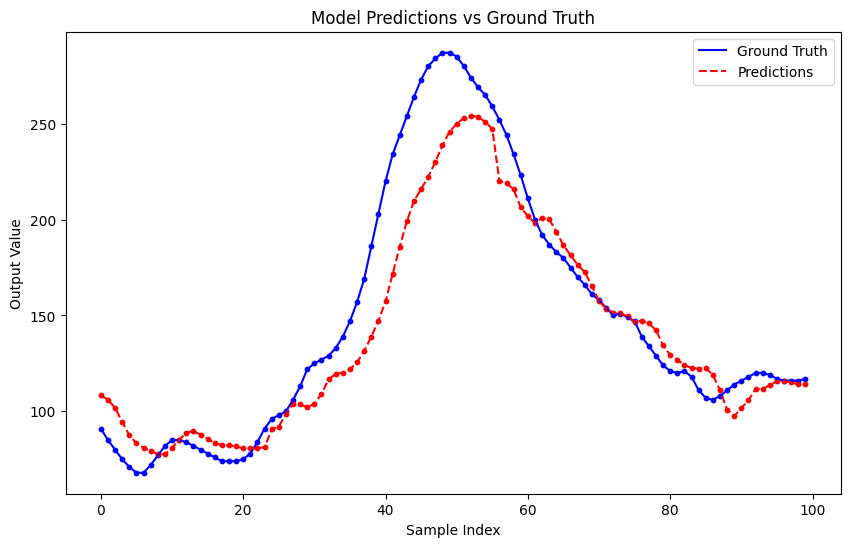

In [16]:


def plot_predictions_vs_targets(predictions, targets):
    plt.figure(figsize=(10, 6))
    plt.plot(targets, label='Ground Truth', color='blue')
    plt.plot(predictions, label='Predictions', color='red', linestyle='--')
    plt.scatter(range(len(targets)), targets, color='blue', s=10)  # Ground truth points
    plt.scatter(range(len(predictions)), predictions, color='red', s=10)  # Prediction points
    plt.title('Model Predictions vs Ground Truth')
    plt.xlabel('Sample Index')
    plt.ylabel('Output Value')
    plt.legend()
    plt.show()

plot_predictions_vs_targets(predictions[200:300], targets[200:300])

In [ ]:
import torch
from sklearn.metrics import mean_squared_error

def rmse_pytorch(predictions, targets):
    # Convert predictions and targets to float tensors if they are not already
    predictions = predictions.float()
    targets = targets.float()
    
    # Calculate MSE
    # mse = torch.mean((predictions - targets) ** 2)
    mse = mean_squared_error(targets, predictions)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    return rmse

# Example usage:
# predictions, targets should be PyTorch tensors
# Assuming predictions and targets are already defined:
rmse_value = rmse_pytorch(torch.tensor(predictions), torch.tensor(targets))
print(f'RMSE: {rmse_value.item()}')

# For all subjects

In [8]:
sequence_window = 12 # *5
prediction_horizon = 6 # *5 minute ahead
hidden_size = 256
output_size = 1
num_epochs = 100

In [10]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        # print("Shape after RNN:", out.shape)  # Debugging: Check shape after RNN
        # out = out[:, -1, :]
        # print("Shape before FC:", out.shape)  # Debugging: Check shape before FC
        out = self.fc(out)
        return out

In [12]:
# Model parameters from Paper 4
sequence_window = 6  # 12 * 5 = 60 minutes
prediction_horizon = 6  # 6 * 5 = 30 minutes ahead
hidden_size = 256  # Hidden size as described for the best model in the paper
output_size = 1  # Output is the predicted glucose level
num_epochs = 100  # Number of epochs for training

class StackedLSTMModel(nn.Module):
    def __init__(self, input_features, hidden_dim, output_features, num_layers=2):
        super(StackedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_features, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_features)
        self.dropout = nn.Dropout(0.3)  # Adding dropout for regularization
    
    def forward(self, x):
        # Forward pass through LSTM layers
        lstm_out, _ = self.lstm(x)
        # Apply dropout to the output of the last LSTM layer
        lstm_out = self.dropout(lstm_out)  # Taking the output of the last time step
        # Pass the output through the fully connected layer
        y_pred = self.fc(lstm_out)
        return y_pred

In [11]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)  # Move data to the correct device
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate_epoch(model, loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)  # Move data to the correct device
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(loader)

In [12]:
def get_predictions_and_targets(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure model is on the right device
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)  # Move data & target to the same device as model
            output = model(data)
            predictions.extend(output.detach().cpu().numpy())  # Move output back to CPU for storage/manipulation
            targets.extend(target.detach().cpu().numpy())
    return predictions, targets


In [13]:
from sklearn.metrics import mean_squared_error

def rmse_pytorch(predictions, targets):
    # Convert predictions and targets to float tensors if they are not already
    predictions = predictions.float()
    targets = targets.float()
    
    # Calculate MSE
    # mse = torch.mean((predictions - targets) ** 2)
    mse = mean_squared_error(targets, predictions)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    return rmse



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")
rmse_list = []

for subj in train_file_names:
    # res = preprocess_DiaTrend(f"../DiaTrend/train/{subj}.csv") # for Diatrend, it's csv, for 
    res = preprocess_t1dexi(f"../LB_split/training/{subj}.csv")
    # reconstruct_data = create_sequences(res[0], sequence_window, prediction_horizon)
    # Loop thru all subjects to stack the data
    X_stack_tensor = []
    y_stack_tensor = []

    for ii in res:
        reconstruct_data = create_sequences(ii, sequence_window, prediction_horizon) # sequence length = 6(30min), pediction_horizon = 3(predict 15 minutes ahead)
        X_stack_tensor.append(reconstruct_data[0])
        y_stack_tensor.append(reconstruct_data[1])
    
    all_sequences = torch.cat(X_stack_tensor, dim=0) # yy_0 includes the X
    all_targets = torch.cat(y_stack_tensor, dim=0) # yy_1 includes the y label
    sequences_train, sequences_val, targets_train, targets_val = train_test_split(
        all_sequences, all_targets, test_size=0.2, shuffle=False
    )

    # Build the data loader and model
    train_dataset = TensorDataset(sequences_train, targets_train)
    val_dataset = TensorDataset(sequences_val, targets_val)
    train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Model parameters
    input_size = sequences_train.shape[-1]  # Number of features

    # Model instantiation
    model_rnn = RNNModel(input_size, hidden_size, output_size).to(device)

    # Loss and optimizer
    # Loss and optimizer
    criterion = nn.L1Loss()  # Using L1 Loss to approximate MAPE since PyTorch does not have a direct MAPE function
    optimizer = torch.optim.RMSprop(model_rnn.parameters(), lr=0.0001)  # Using RMSprop optimizer with a learning rate of 0.001


    # Training
    for epoch in range(num_epochs):
        train_loss = train_epoch(model_rnn, train_data_loader, optimizer, device)
        val_loss = validate_epoch(model_rnn, val_data_loader, device)
        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}')

    # Assuming model and val_loader are already defined
    predictions, targets = get_predictions_and_targets(model_rnn, val_data_loader)
    rmse_value = rmse_pytorch(torch.tensor(predictions), torch.tensor(targets))
    rmse_list.append(rmse_value)
    print(f'RMSE: {rmse_value.item()}')
    print(f"=================================================")
